## Installing and importing required libraries

In [ ]:
pip install ydata-profiling optuna pygam

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081

In [ ]:
import kagglehub
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pl

import warnings
import optuna
from optuna.visualization import plot_optimization_history,plot_param_importances

from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import RobustScaler,PolynomialFeatures,SplineTransformer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, auc,r2_score,accuracy_score,mean_squared_error

from patsy import dmatrix
from pygam import LinearGAM,s
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam,BSplines
from xgboost import XGBRegressor

import shap

In [ ]:
kagglehub.login()

## Exploratory Data Analysis and Data Cleaning

In [ ]:
#Downloading and reading datasets
rul_path=kagglehub.dataset_download('ignaciovinuales/battery-remaining-useful-life-rul')
data=pd.read_csv(os.path.join(rul_path,'Battery_RUL.csv'))

100%|██████████| 374k/374k [00:00<00:00, 42.7MB/s]

Extracting files...


In [ ]:
#Sample of data
data.head()

Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0          1.0             2595.30             1151.488500   
1          2.0             7408.64             1172.512500   
2          3.0             7393.76             1112.992000   
3          4.0             7385.50             1080.320667   
4          6.0            65022.75            29813.487000   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                      3.670                    3.211           5460.001   
1                      4.246                    3.220           5508.992   
2                      4.249                    3.224           5508.993   
3                      4.250                    3.225           5502.016   
4                      4.290                    3.398           5480.992   

   Time constant current (s)  Charging time (s)   RUL  
0                    6755.01           10777.82  1112  
1                    6762.02           10500.35  1111  
2                    6762.02           10420.38  1110  
3                    6762.02           10322.81  1109  
4                   53213.54           56699.65  1107

In [ ]:
#plotting function for prediction results
def plot_results(trainging_Y_pred,test_Y_pred):
    fig=plt.figure(layout='constrained',figsize=(10,5))
    fig.suptitle("Prediction scatter plots")
    train,test=fig.subfigures(2,1)
    train.suptitle("Training data")
    test.suptitle("Test data")
    ax_train=train.subplots(1,2)
    ax_test=test.subplots(1,2)

    ax_train[0].set_xlabel("Actual RUL")
    ax_train[0].set_ylabel("Predictors average value")
    ax_train[0].scatter(y_train,train_predictors_avg,c='r')

    ax_train[1].set_xlabel("Predicted RUL")
    ax_train[1].set_ylabel("Predictors")
    ax_train[1].scatter(trainging_Y_pred,train_predictors_avg,c='b')

    ax_test[0].set_xlabel("Actual RUL")
    ax_test[0].set_ylabel("Predictor average")
    ax_test[0].scatter(y_test,test_predictors_avg,c='r')

    ax_test[1].set_xlabel("Predicted RUL")
    ax_test[1].set_ylabel("Predictor Average")
    ax_test[1].scatter(test_Y_pred,test_predictors_avg,c='b')

    print("\n")
    plt.show()
    print("\n\n")

#General purpose plotting function
def plot_data(Labels,Data,Title):
  fig = plt.figure(figsize=(10, 5))
  fig.suptitle(Title)
  ax = fig.subplots(1, 1)
  ax.set_xlabel(Labels[0])
  ax.set_ylabel(Labels[1])
  ax.scatter(Data[0],Data[1],c='b')
  plt.grid(True)
  plt.show()
  print("\n\n")

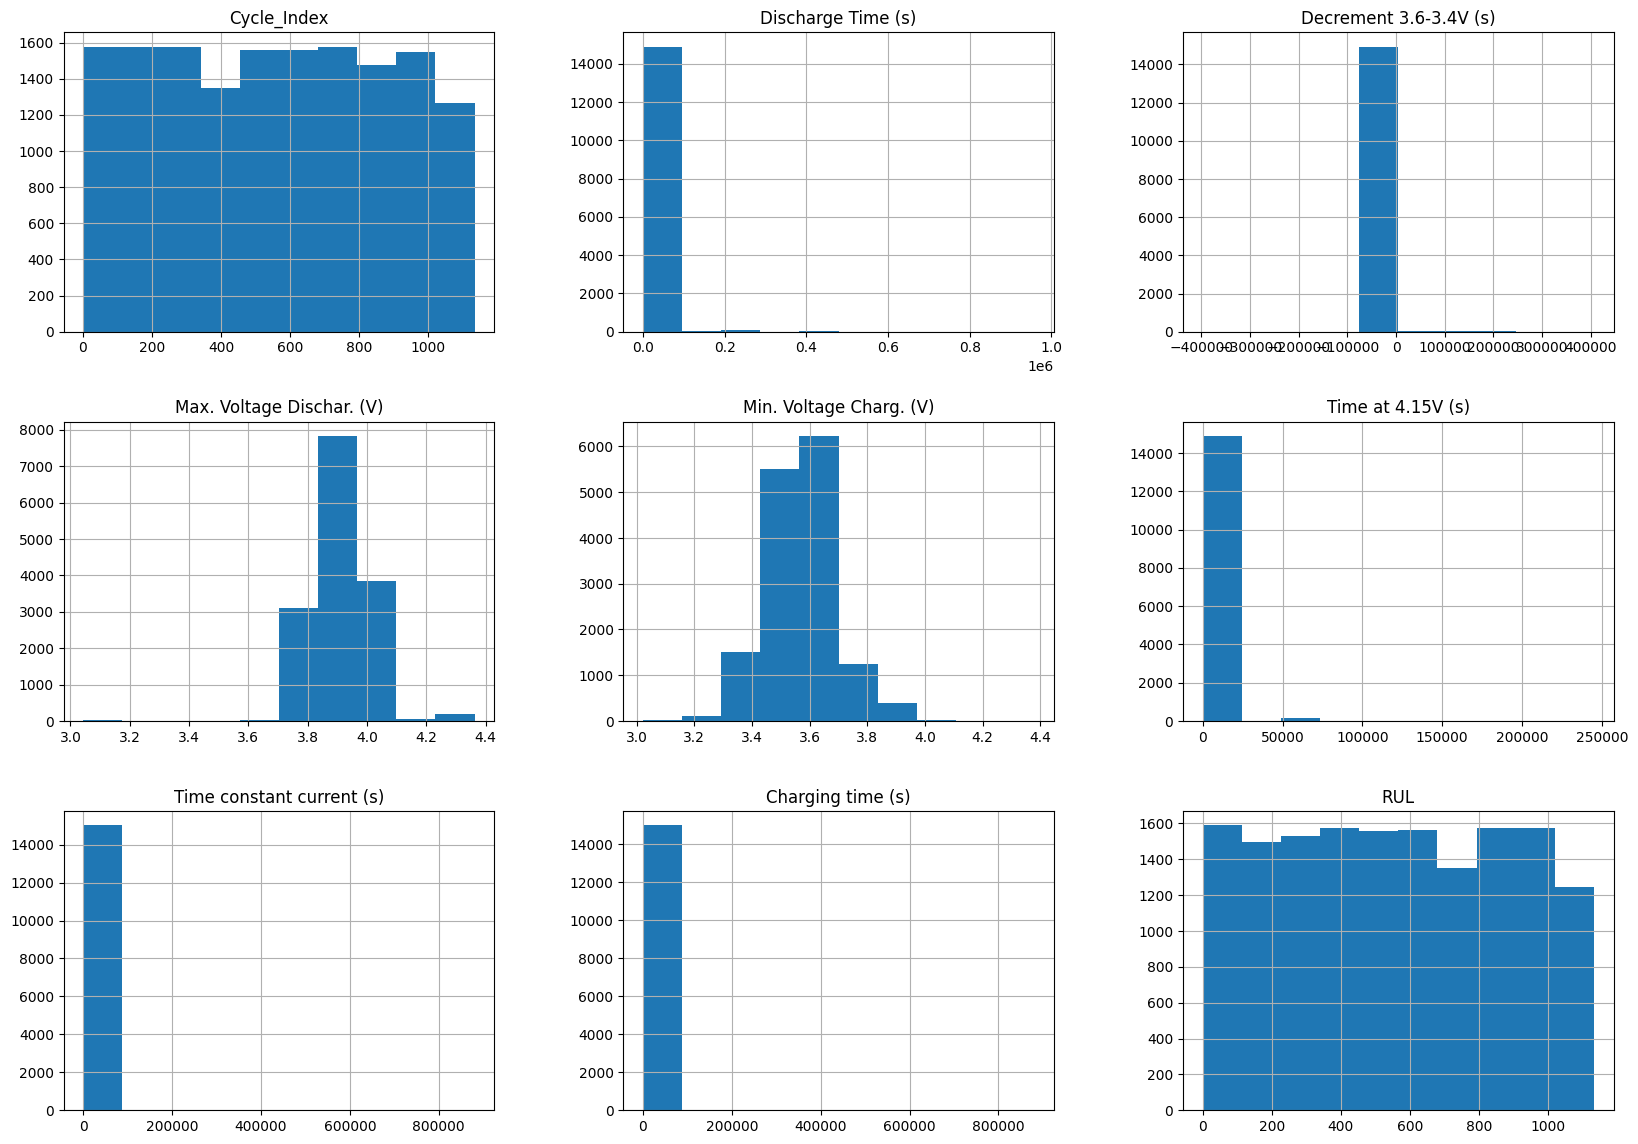

In [ ]:
#Data histograms
histograms = data.hist(figsize=(20, 14))

In [ ]:
#Pipeline to fit and transform data
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar

    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y

    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y

robust = RobustScaler()
pipeline = Pipeline(robust)

In [ ]:
#Detailed information about data
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

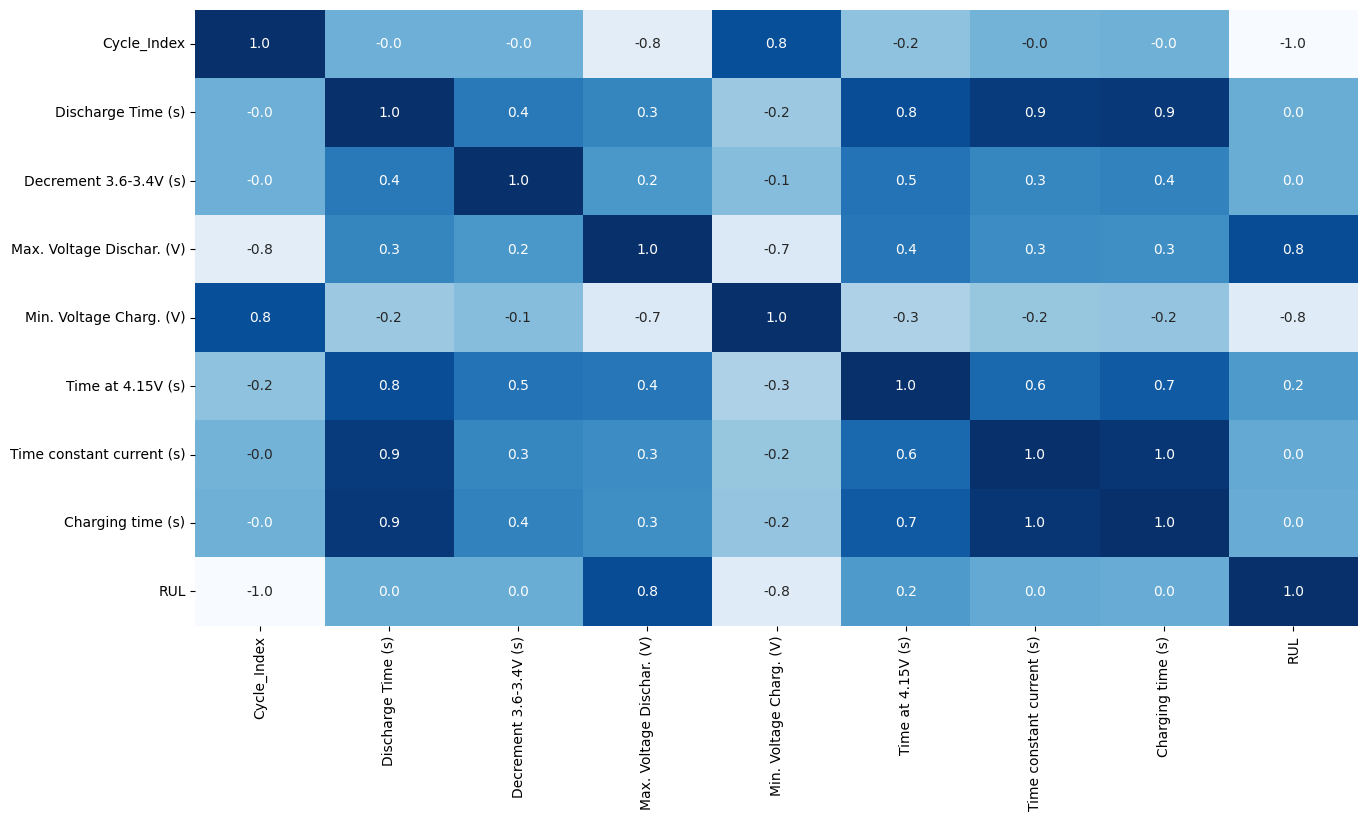

In [ ]:
#Cycle Index is repeating hence will not be useful
columns_to_drop = ['Cycle_Index']

#Plotting correlation heatmap
plt.figure(figsize = (15,8))
sns.heatmap(data.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [ ]:
#Adding parameters with no correlation to RUL
columns_to_drop.extend(['Discharge Time (s)','Decrement 3.6-3.4V (s)','Time constant current (s)','Charging time (s)'])

#Dropping unecessary parameters
X=data.drop(columns_to_drop,axis=1)

#Seperating features and response
X = X.drop('RUL',axis=1)
y = data['RUL']


In [ ]:
X.head()

Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)
0                      3.670                    3.211           5460.001
1                      4.246                    3.220           5508.992
2                      4.249                    3.224           5508.993
3                      4.250                    3.225           5502.016
4                      4.290                    3.398           5480.992

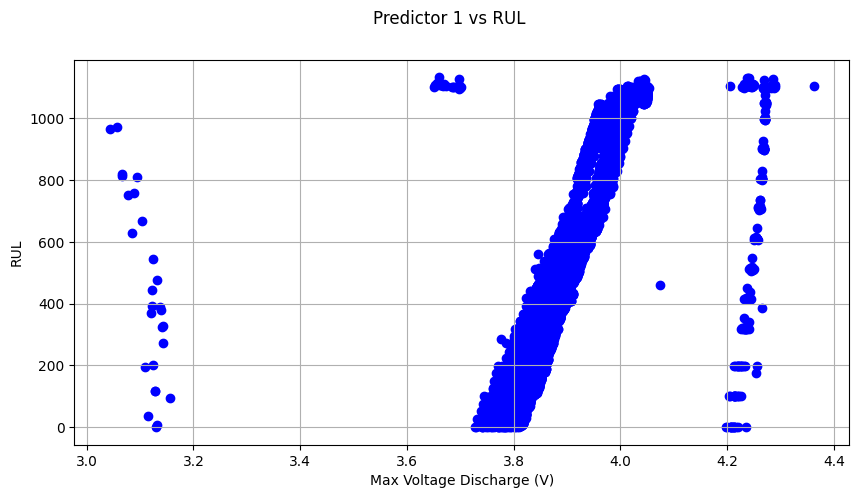

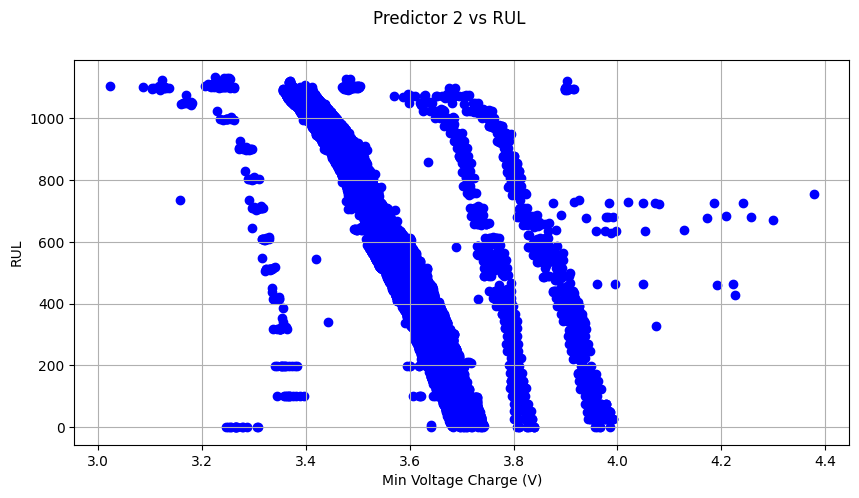

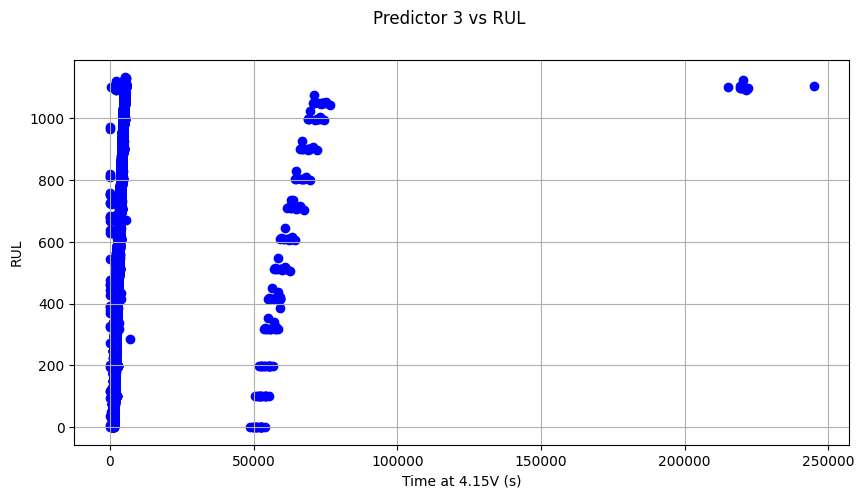

In [ ]:
#Plotting predictors vs response scatter plots
plot_data(['Max Voltage Discharge (V)','RUL'],[X['Max. Voltage Dischar. (V)'],y],"Predictor 1 vs RUL")

plot_data(['Min Voltage Charge (V)','RUL'],[X['Min. Voltage Charg. (V)'],y],"Predictor 2 vs RUL")

plot_data(['Time at 4.15V (s)','RUL'],[X['Time at 4.15V (s)'],y],"Predictor 3 vs RUL")

In [ ]:
#Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2023, shuffle =True)

#Converting training and test sets using RobustScaler
X_train, y_train = pipeline.fit(X_train, y_train)
X_test, y_test = pipeline.transform(X_test, y_test)

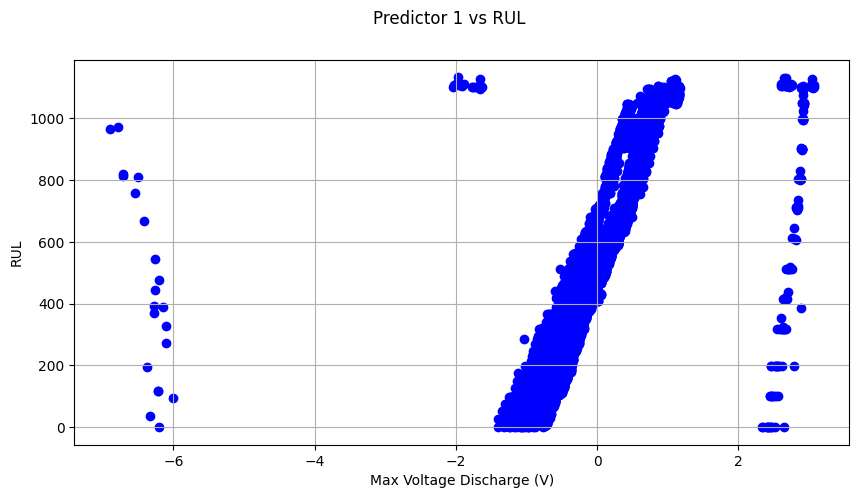

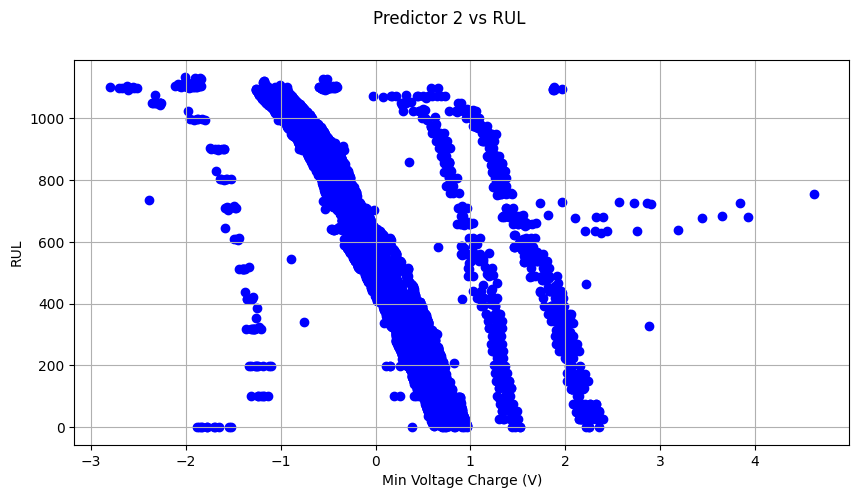

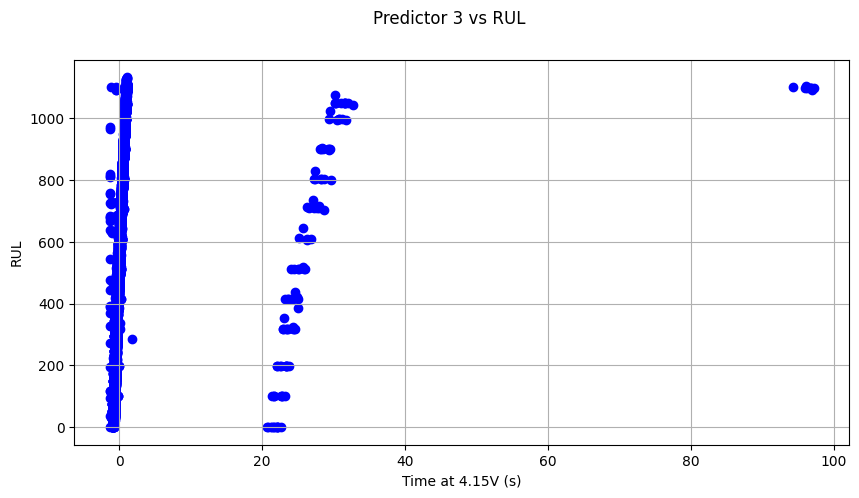

In [ ]:
#Plotting features vs response scatterplots for training set
plot_data(['Max Voltage Discharge (V)','RUL'],[X_train[:,0],y_train],"Predictor 1 vs RUL")

plot_data(['Min Voltage Charge (V)','RUL'],[X_train[:,1],y_train],"Predictor 2 vs RUL")

plot_data(['Time at 4.15V (s)','RUL'],[X_train[:,2],y_train],"Predictor 3 vs RUL")

In [ ]:
#identifying locations for knots for each of the parameters
spline_knots = [[-3.5,1.5],[-1.6,1,2.5],[10,30.5]]

In [ ]:
#avearges of row-wise features for comparing actual distribution and prediction distribution
train_predictors_avg=np.average(X_train,axis=1,keepdims=True)
test_predictors_avg=np.average(X_test,axis=1,keepdims=True)

#Declaring dictionary to store models
models = { }

## 1. Linear Regression

Score on Training Set: 72.38%
Root Mean Squared Error:  169.65797226296453
Cross Validation Score: 71.93%

Score on Test Set: 75.64%
Root Mean Squared Error on Test Set:  158.73767224005925




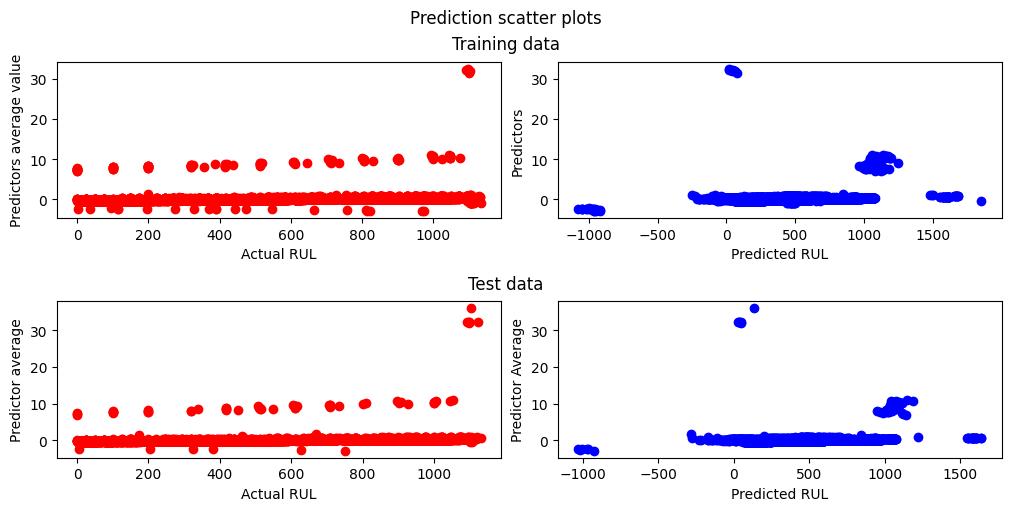

In [ ]:
#Fitting model to training data
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

#Model predictions on training set and test set
y_train_pred = linear_regression.predict(X_train)
y_test_pred = linear_regression.predict(X_test)

#Model Evaluation
train_score = linear_regression.score(X_train, y_train)
test_score = linear_regression.score(X_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
cv_score = np.mean(cross_val_score(linear_regression, X_train, y_train, cv=5))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(cv_score))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_pred,y_test_pred)

#Storing the linear regression model to set of all models
models['Linear Regressor'] = (linear_regression,test_score,rmse_test)

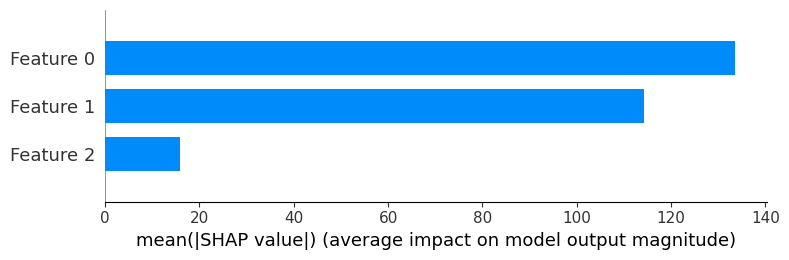

In [ ]:
explainer = shap.LinearExplainer(linear_regression, X_train)
shap_values = explainer.shap_values(X_test)
shap_summary = shap.summary_plot(shap_values, X_test, plot_type="bar")

## 2. Polynomial Regression

Score on Training Set: 89.65%
Root Mean Squared Error:  103.84815013740926
Cross Validation Score: 89.41%

Score on Test Set: 85.37%
Root Mean Squared Error on Test Set:  123.02969693677122




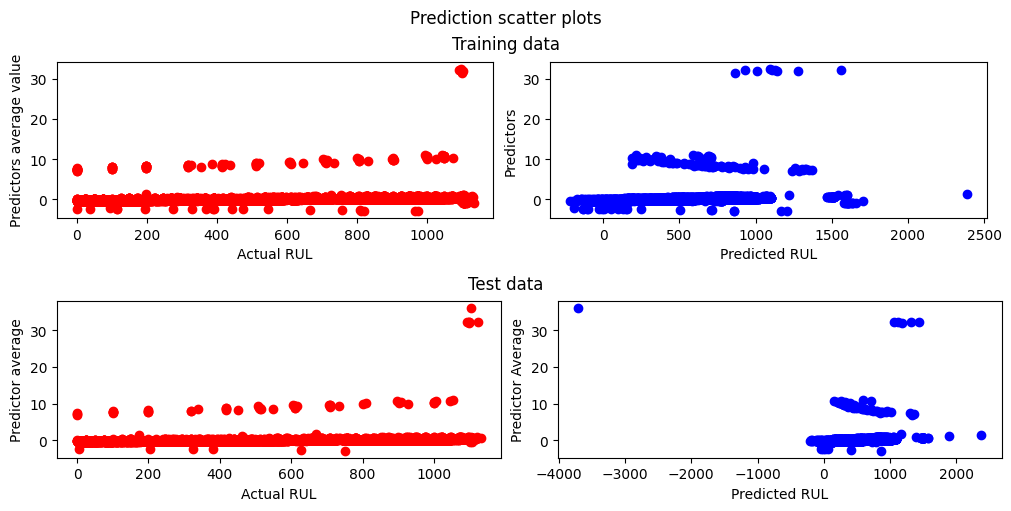

In [ ]:
#Tranforming training and testing data to incprporate polynomial functions
poly=PolynomialFeatures(degree=2,include_bias=False)
X_train_polynomial=poly.fit_transform(X_train)
X_test_polynomial=poly.fit_transform(X_test)

#Fitting model to transformed training data
polynomial_regression = LinearRegression()
polynomial_regression.fit(X_train_polynomial, y_train)

#Model Predictions on training and test data
y_train_pred = polynomial_regression.predict(X_train_polynomial)
y_test_pred = polynomial_regression.predict(X_test_polynomial)

#Model Evaluation
train_score = polynomial_regression.score(X_train_polynomial, y_train)
test_score = polynomial_regression.score(X_test_polynomial, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
cv_score = np.mean(cross_val_score(polynomial_regression, X_train_polynomial, y_train, cv=5))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(cv_score))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_pred,y_test_pred)

#Storing the linear regression model to set of all models
models['Polynomial Regressor'] = (polynomial_regression,test_score,rmse_test)

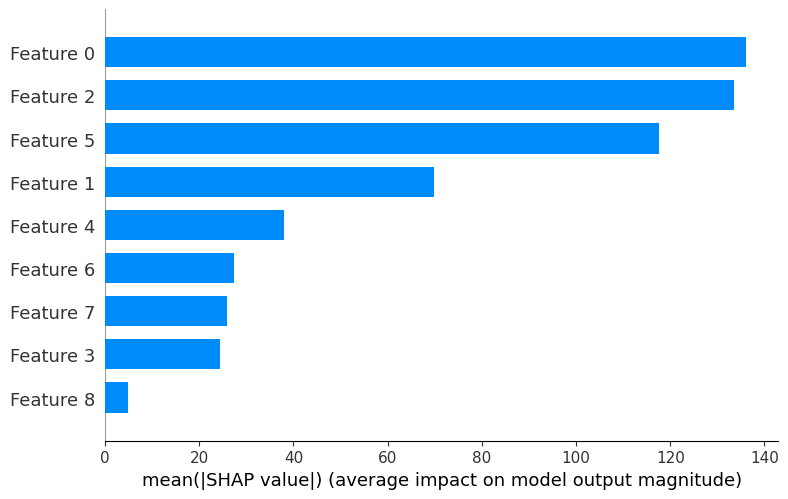

In [ ]:
explainer = shap.LinearExplainer(polynomial_regression, X_train_polynomial)
shap_values = explainer.shap_values(X_test_polynomial)
shap_summary = shap.summary_plot(shap_values, X_test_polynomial, plot_type="bar")

## 3. Natural Splines Regression using patsy library

Score on Training Set: 96.50%
Root Mean Squared Error:  60.35167315650699
Cross Validation Score: 96.16%

Score on Test Set: 95.08%
Root Mean Squared Error on Test Set:  71.37332003675512




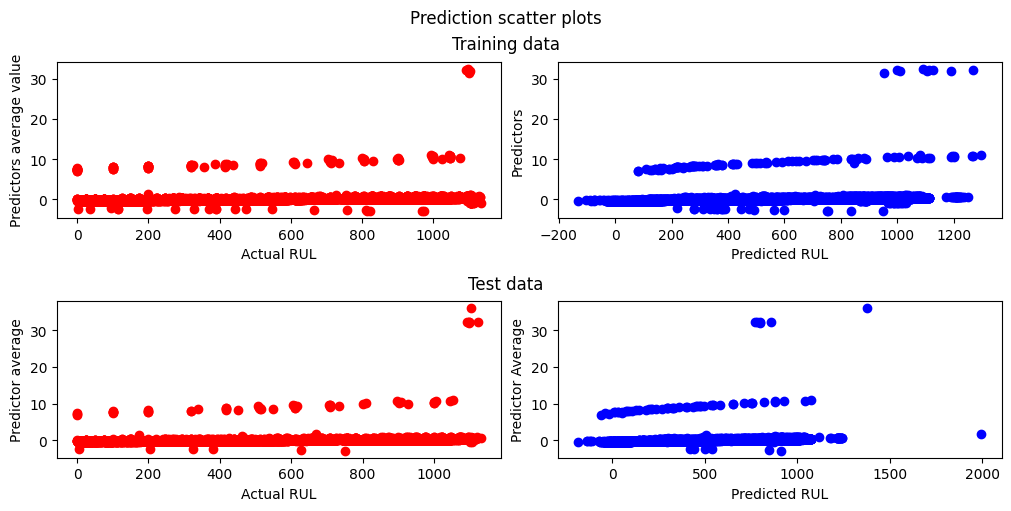

In [ ]:
# Converting numpy arrays X_train and X_test to dataframes
X_train_df = pd.DataFrame(X_train, columns=['x1', 'x2', 'x3'])
X_test_df = pd.DataFrame(X_test, columns=['x1', 'x2', 'x3'])

# Natural Spline basis functions for training and test data
formula = (
    f"bs(x1, knots={spline_knots[0]}, degree=3, include_intercept=False) + "
    f"bs(x2, knots={spline_knots[1]}, degree=3, include_intercept=False) + "
    f"bs(x3, knots={spline_knots[2]}, degree=3, include_intercept=False)"
)

#Converting training and testing sets using defined spline basis functions
spline_basis_train = dmatrix(formula, data=X_train_df, return_type='dataframe')
spline_basis_test = dmatrix(formula, data=X_test_df, return_type='dataframe')

# Fit linear regression on the transformed training data
spline_regression = LinearRegression()
spline_regression.fit(spline_basis_train, y_train)

# Model predictions on training and testing sets
y_train_pred = spline_regression.predict(spline_basis_train)
y_test_pred = spline_regression.predict(spline_basis_test)

#Model Evaluation
train_score = spline_regression.score(spline_basis_train, y_train)
test_score = spline_regression.score(spline_basis_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
cv_score = np.mean(cross_val_score(spline_regression, spline_basis_train, y_train, cv=5))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(cv_score))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_pred,y_test_pred)

#Storing the linear regression model to set of all models
models['Natural Splines Regressor'] = (spline_regression,test_score,rmse_test)

Knots:  [[-3.5, 1.5], [-1.6, 1, 2.5], [10, 30.5]]


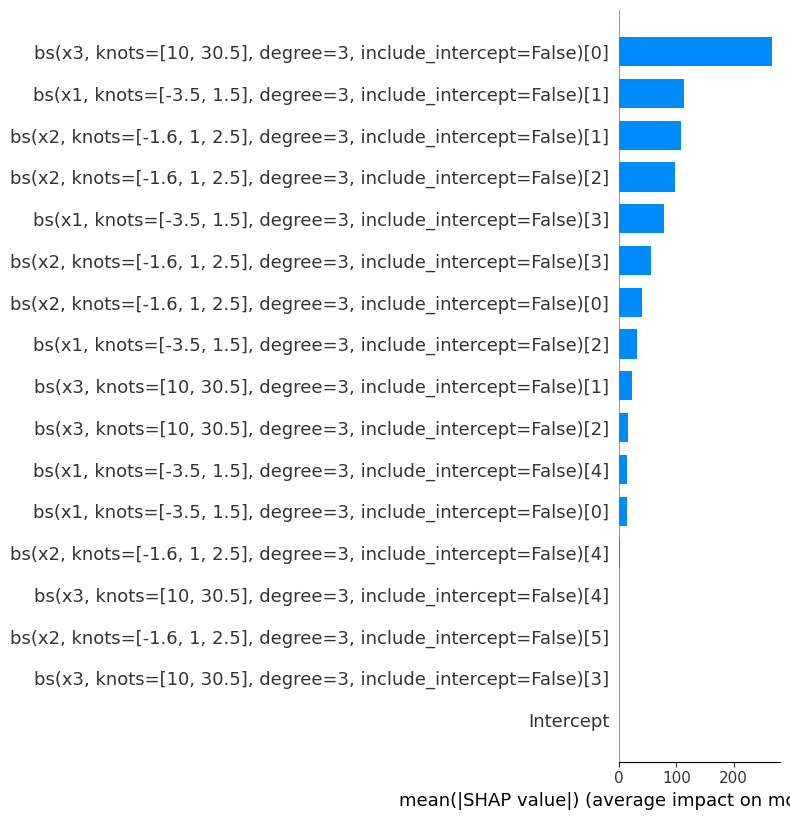

In [ ]:
explainer = shap.LinearExplainer(spline_regression, spline_basis_train)
shap_values = explainer.shap_values(spline_basis_test)
print("Knots: ",spline_knots)
shap_summary = shap.summary_plot(shap_values, spline_basis_test, plot_type="bar")

## 4. GAM using pygam library

100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


Score on Training Set: 97.08%
Root Mean Squared Error:  55.18957977393933

Score on Test Set: 96.79%
Root Mean Squared Error on Test Set:  57.627981425126016




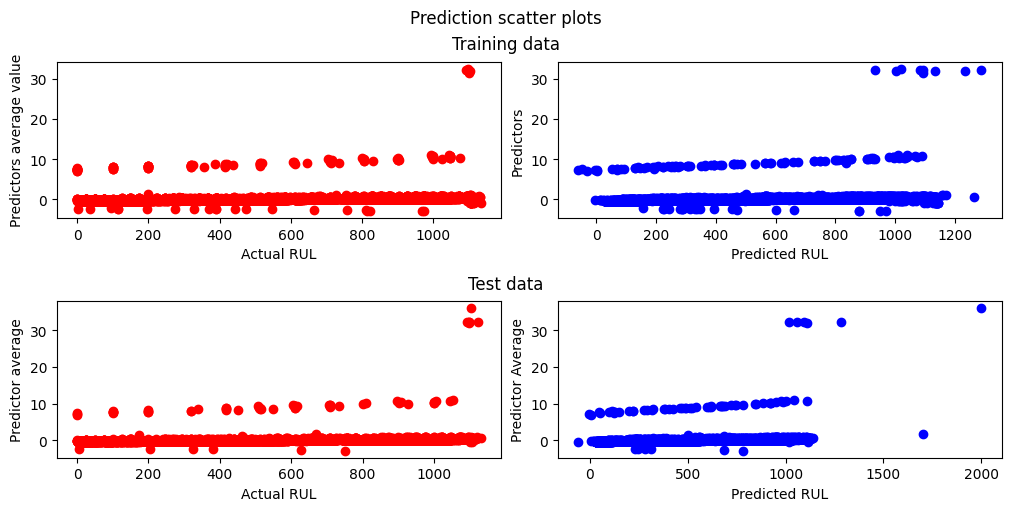

In [ ]:
#Declaring GAM model and findidng tuning parameters using gridsearch
gam = LinearGAM(s(0)+s(1)+s(2)).gridsearch(X_train, y_train)

#Fitting the best model with training data
gam.fit(X_train, y_train)

#Model predictions on training and test data
y_train_pred = gam.predict(X_train)
y_test_pred = gam.predict(X_test)

#Model Evaluation
train_score = gam.score(X_train, y_train)
test_score = gam.score(X_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_pred,y_test_pred)

#Storing the linear regression model to set of all models
models['GAM regressor'] = (gam,test_score,rmse_test)

  0%|          | 0/100 [00:00<?, ?it/s]

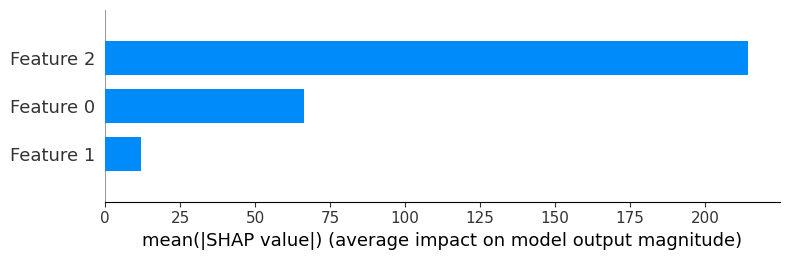

In [ ]:
def gam_predict(X):
    return gam.predict(X)

test_subset = shap.sample(X_test,100)
explainer = shap.KernelExplainer(gam_predict,shap.sample(X_train,50))
shap_values = explainer.shap_values(test_subset)
shap_summary = shap.summary_plot(shap_values,test_subset, plot_type="bar")

## 5. K-Nearest Regression

Score on Training Set: 99.59%
Root Mean Squared Error:  20.774143954225202
Cross Validation Score: 99.04%

Score on Test Set: 99.13%
Root Mean Squared Error on Test Set:  29.945238449566176




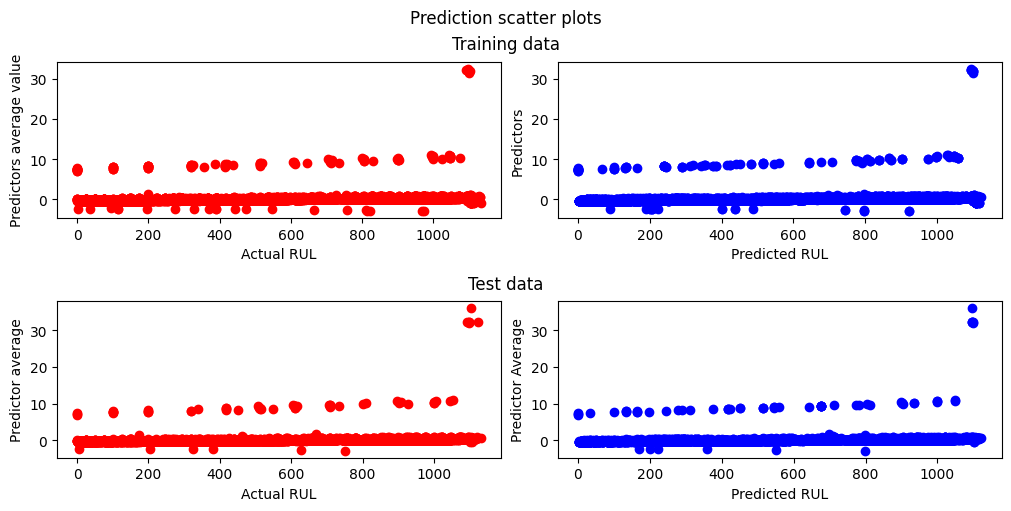

In [ ]:
#Fitting model with training data
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train,y_train)

#Model Predictions for training and test data
y_train_predictions = knn_model.predict(X_train)
y_test_predictions = knn_model.predict(X_test)


#Model Evaluation
train_score = knn_model.score(X_train, y_train)
test_score = knn_model.score(X_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predictions))
cv_score = cross_val_score(knn_model, X_train, y_train, cv=5)

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(np.mean(cv_score)))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_predictions,y_test_predictions)

#Storing the linear regression model to set of all models
models['KNN Regressor'] = (knn_model,test_score,rmse_test)

  0%|          | 0/100 [00:00<?, ?it/s]

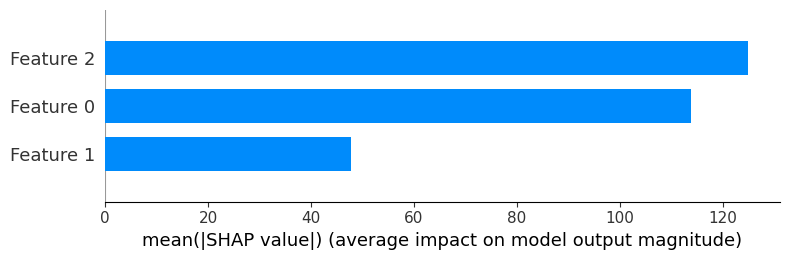

In [ ]:
def knn_predict(X):
    return knn_model.predict(X)

explainer = shap.KernelExplainer(knn_predict,shap.sample(X_train,50))
shap_values = explainer.shap_values(test_subset)
shap_summary = shap.summary_plot(shap_values, test_subset, plot_type="bar")

## 6. Support Vector Regression

Score on Training Set: 97.34%
Root Mean Squared Error:  52.67853442259817
Cross Validation Score: 97.25%

Score on Test Set: 97.36%
Root Mean Squared Error on Test Set: 52.22291893393554




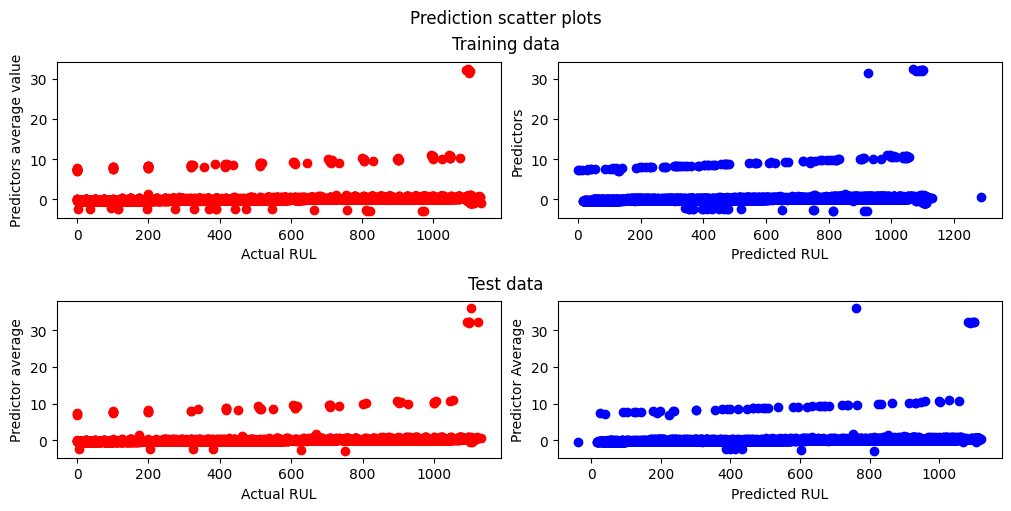

In [ ]:
# Fit the model to the training data
svm_regressor = SVR(kernel='rbf',gamma='auto',C=100)
svm_regressor.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_train=svm_regressor.predict(X_train)
y_pred_test = svm_regressor.predict(X_test)

#Model Evaluation
train_score = svm_regressor.score(X_train, y_train)
test_score = svm_regressor.score(X_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
cv_score = cross_val_score(svm_regressor, X_train, y_train, cv=5)

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(np.mean(cv_score)))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set:",rmse_test)

#Plotting model predictions
plot_results(y_pred_train,y_pred_test)

#Storing the linear regression model to set of all models
models['SVM Regressor'] = (svm_regressor,test_score,rmse_test)

  0%|          | 0/100 [00:00<?, ?it/s]

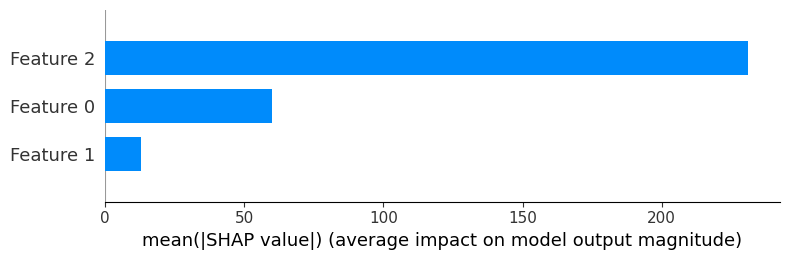

In [ ]:
def svm_predict(X):
    return svm_regressor.predict(X)

explainer = shap.KernelExplainer(svm_predict,shap.sample(X_train,50))
shap_values = explainer.shap_values(test_subset)
shap_summary = shap.summary_plot(shap_values, test_subset, plot_type="bar")

## 7. Decision Tree Regression

In [ ]:
#Defining objective function for optimization
def objective_DecisionTree(trial):
    #Defining range of hyperparameters
    max_depth = trial.suggest_categorical('max_depth', [None, 5, 10])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 21)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11)

    #Defining model with suggested hyperparameters
    decision_tree = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    #Finding cross validation negative mean squared error of current model
    score = np.mean(cross_val_score(
        decision_tree,
        X_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    ))
    return score

# To prevent console messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

#Creating a study and optimizng cross validation negative mean squared of model
study = optuna.create_study(direction='maximize')
study.optimize(objective_DecisionTree, n_trials=50)

#Best hyperparameter after optimization
print("Best parameters: ",study.best_params,"\n");

Best parameters:  {'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 2} 



In [ ]:
#Plotting optimization history
plot_optimization_history(study)

Score on Training Set: 99.69%
Root Mean Squared Error on Training Set:  18.0671868771257
Cross validation score:98.37%

Score on Test Set: 98.55%
Root Mean Squared Error on Test Set:  38.66470477059761




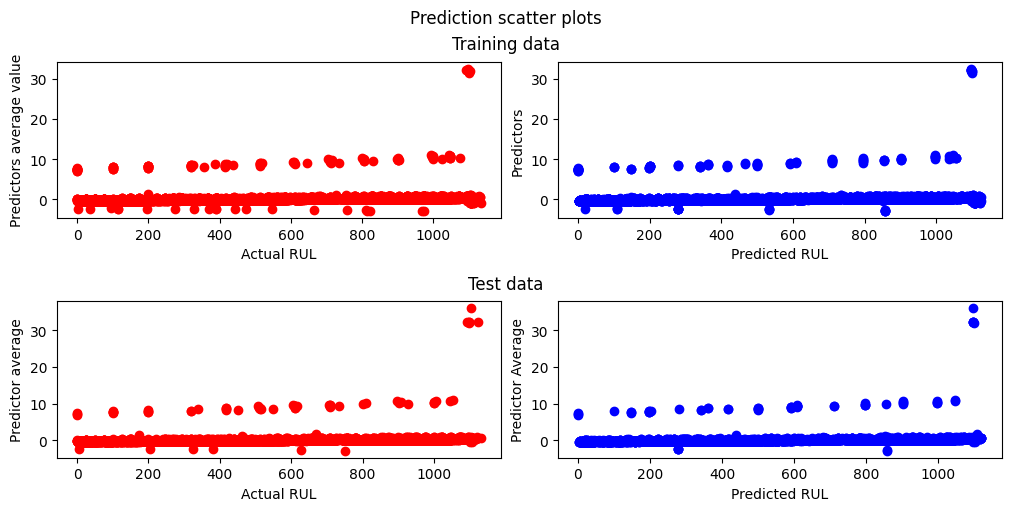

In [ ]:
#Fitting model with best hyperparameters to training data
dt_regression=DecisionTreeRegressor(**study.best_params);
dt_regression.fit(X_train,y_train)

#Model predictions on training and test data
y_train_predictions = dt_regression.predict(X_train)
y_test_predictions = dt_regression.predict(X_test)

#Evaluating Model performance
train_score = dt_regression.score(X_train, y_train)
test_score = dt_regression.score(X_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predictions))
cv_score = np.mean(cross_val_score(dt_regression, X_train, y_train, cv=5))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error on Training Set: ",rmse_train)
print("Cross validation score:{:.2%}".format(cv_score))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_predictions,y_test_predictions)

#Storing the linear regression model to set of all models
models['Decision Tree Regressor'] = (dt_regression,test_score,rmse_test)

## 8. Random Forest Regression

In [ ]:
#Defining objective function for optimization
def objective_RandomForest(trial):
  #Defining hyperparameter ranges
  n_estimators=trial.suggest_categorical('n_estimators',[50,100,150])
  max_depth = trial.suggest_categorical('max_depth', [None, 5,10,15])
  min_samples_split=trial.suggest_int('min_samples_split',2,15)
  min_samples_leaf=trial.suggest_int('min_samples_leaf',1,5)

  #Defining model with suggested hyperparameters
  random_forest=RandomForestRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      random_state=42
    )

  #Finding cross validation negative mean squared of the current model
  score=np.mean(cross_val_score(
      random_forest,
      X_train,
      y_train,
      cv=5,
      scoring='neg_mean_squared_error',
      ))
  return score

#To prevent console messages
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

#Creating a study and optimizng cross validation negative mean squared of model
study=optuna.create_study(direction='maximize')
study.optimize(objective_RandomForest,n_trials=10)

#Best parameters after optimization
print("Best parameters: ",study.best_params,"\n");

Best parameters:  {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2} 



In [ ]:
#Plotting optimazation history
plot_optimization_history(study)

Score on Training Set: 99.62%
Root Mean Squared Error:  19.985244277960433
Cross Validation Score: 98.84%

Score on Test Set: 99.05%
Root Mean Squared Error on Test Set:  31.39423044811976




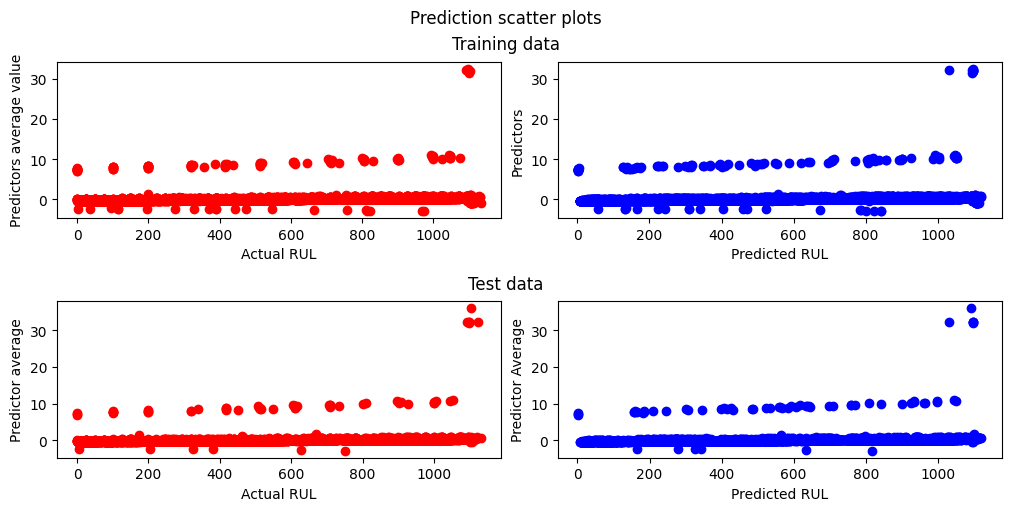

In [ ]:
#Fitting training data to model with best hyperparamters
rf_regression=RandomForestRegressor(**study.best_params,random_state=42);
rf_regression.fit(X_train,y_train)

#Model predictions on training and test data
y_train_predictions = rf_regression.predict(X_train)
y_test_predictions = rf_regression.predict(X_test)

#Model evaluations
train_score = rf_regression.score(X_train, y_train)
test_score = rf_regression.score(X_test, y_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predictions))
cv_score = cross_val_score(rf_regression, X_train, y_train, cv=5)

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(np.mean(cv_score)))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_predictions,y_test_predictions)

#Storing the linear regression model to set of all models
models['Random Forest Regressor'] = (rf_regression,test_score,rmse_test)

## 9. XGBoost Regression

In [ ]:
#Defining objective function for optimization
def objective_XGBoost(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_categorical('max_depth', [None, 5, 10, 15, 20])
    gamma = trial.suggest_float('gamma', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Define the model
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='reg:squarederror',
        random_state=42
    )

    # Cross-validation
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'
    )
    return np.mean(score)

# Create and optimize the study
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction="maximize")
study.optimize(objective_XGBoost, n_trials=10)

# Print the best parameters
print("Best parameters: ", study.best_params, "\n")


Best parameters:  {'n_estimators': 271, 'max_depth': 10, 'gamma': 0.43753521272294515, 'learning_rate': 0.07133692337551785, 'subsample': 0.8002681468519931, 'colsample_bytree': 0.672947023737783} 



In [ ]:
# Plotting optimization history
plot_optimization_history(study)

Score on Training Set: 99.66%
Root Mean Squared Error:  18.74344635487531

Score on Test Set: 98.72%
Root Mean Squared Error on Test Set:  36.12091402783326




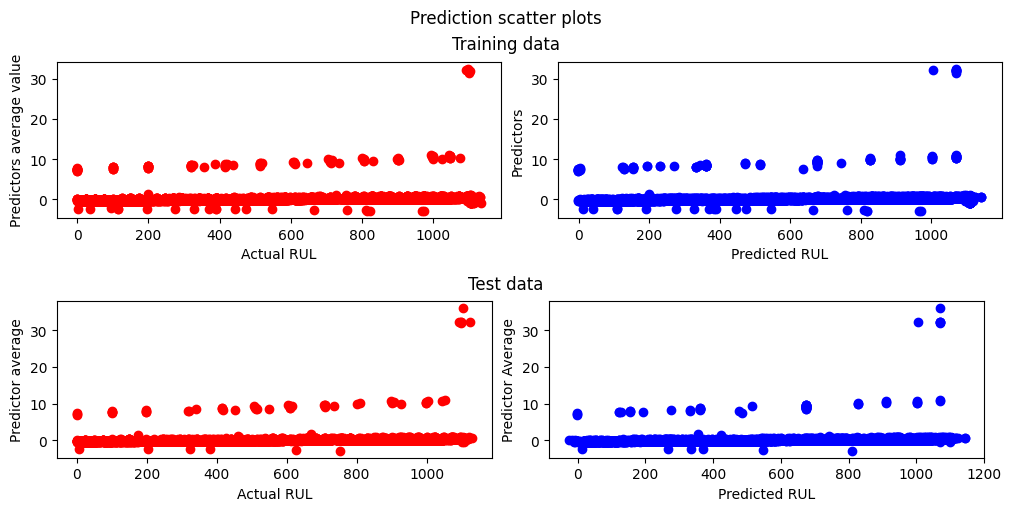

In [ ]:
# Fit the model to the training data
xgb_regression = XGBRegressor(**study.best_params,objective="reg:squarederror",random_state=42)
xgb_regression.fit(X_train,y_train)

#Predictions on training and test set
y_train_pred = xgb_regression.predict(X_train)
y_test_pred = xgb_regression.predict(X_test)

#Evaluating the model
train_score = r2_score(y_train_pred,y_train)
train_rms   = np.sqrt(mean_squared_error(y_train,y_train_pred))

test_score  = r2_score(y_test_pred,y_test)
test_rms    = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",train_rms)
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ",test_rms)

# Plotting model predictions
plot_results(y_train_pred,y_test_pred)

#Storing the regression model to set of all models
models['XGBoost Regressor'] = (xgb_regression,test_score,rmse_test)

## 10. Voting Regressor

In [ ]:
#Defining estimators for VotingRegressor
estimators = [('rf',models['Random Forest Regressor'][0]),
              ('xgb',models['XGBoost Regressor'][0]),
              ('knn',models['KNN Regressor'][0])]

#Defining objective function to optimize
def objective_VotingRegressor(trial):
    # Define hyperparameter search space
    weight_1 = trial.suggest_float('weight_1', 0.0,1)
    weight_2 = trial.suggest_float('weight_2', 0.0,1)
    weight_3 = trial.suggest_float('weight_3', 0.0,1)

    model = VotingRegressor(estimators=estimators,
                            weights=[weight_1,weight_2,weight_3])

    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5,scoring='neg_mean_squared_error'))
    return cv_score

#Optimizing the objective function
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction="maximize")
study.optimize(objective_VotingRegressor, n_trials=10)

# Print the best parameters
print("Best parameters: ", study.best_params, "\n")

In [ ]:
plot_optimization_history(study)

Score on Training Set: 99.71%
Root Mean Squared Error:  17.275770940587723
Cross Validation Score: 99.10%

Score on Test Set: 99.23%
Root Mean Squared Error on Test Set:  28.20131260561839




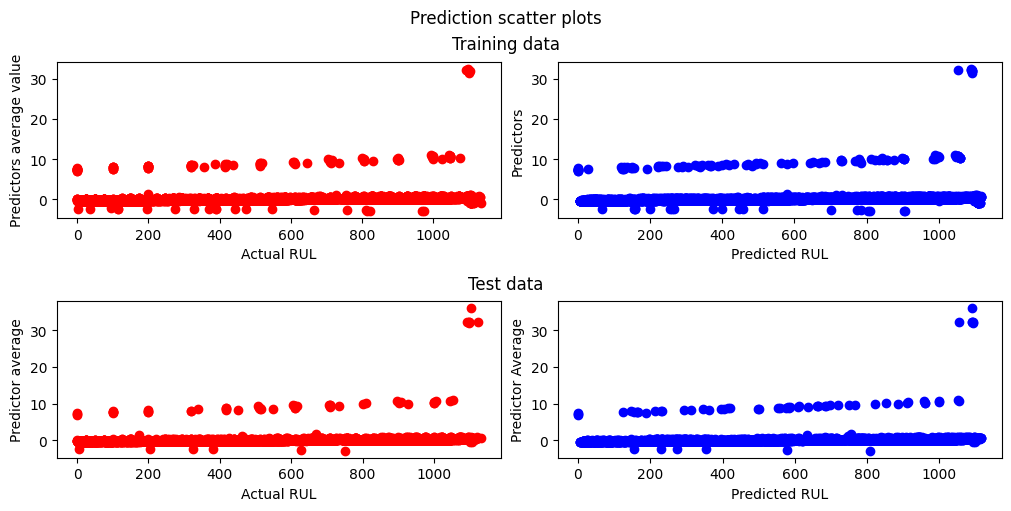

In [ ]:
#Accomoadating individual weights into a single list
weights = [study.best_params['weight_1'],study.best_params['weight_2'],study.best_params['weight_3']]

#Fitting estimators and weights
voting_regressor = VotingRegressor(estimators=estimators,
                                weights=weights)
voting_regressor.fit(X_train,y_train)

#Model predictions
y_train_pred = voting_regressor.predict(X_train)
y_test_pred = voting_regressor.predict(X_test)

#Model evaluation
train_score = voting_regressor.score(X_train, y_train)
rmse_train  = np.sqrt(mean_squared_error(y_train,y_train_pred))
cv_score = np.mean(cross_val_score(voting_regressor, X_train, y_train, cv=5))

test_score = voting_regressor.score(X_test, y_test)
rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("Score on Training Set: {:.2%}".format(train_score))
print("Root Mean Squared Error: ",rmse_train)
print("Cross Validation Score: {:.2%}".format(cv_score))
print("\nScore on Test Set: {:.2%}".format(test_score))
print("Root Mean Squared Error on Test Set: ", rmse_test)

#Plotting model predictions
plot_results(y_train_pred,y_test_pred)

#Storing thr regression model into set of all models
models['Voting Regressor'] = (voting_regressor,test_score,rmse_test)

## Evaluating the models

In [ ]:
print(f"{'Model':<30}{'R^2 (%)':<20}{'MSE':<20}")
print("=" * 60)

for model_name, (model_obj, r2, mse) in models.items():
    print(f"{model_name:<30}{r2*100:<20.2f}{mse:<20.2f}")


Model                         R^2 (%)             MSE                 
Linear Regressor              75.64               158.74              
Polynomial Regressor          85.37               123.03              
Natural Splines Regressor     95.08               71.37               
GAM regressor                 96.79               57.63               
KNN Regressor                 99.13               29.95               
SVM Regressor                 97.36               52.22               
Decision Tree Regressor       98.55               38.66               
Random Forest Regressor       99.05               31.39               
XGBoost Regressor             98.72               31.39               
Voting Regressor              99.23               28.20               
